In [17]:
from jax import jit, random
import pandas as pd
from datetime import datetime, timedelta
import numpyro
from numpyro import distributions as dist
from numpyro import infer
import arviz as az
from IPython.display import Markdown
from plotly.express.colors import qualitative as qual_colours
import pathlib
import math

from estival.sampling import tools as esamp

from emu_renewal.process import CosineMultiCurve
from emu_renewal.distributions import GammaDens
from emu_renewal.renew import RenewalModel
from emu_renewal.outputs import get_spaghetti_from_params, get_quant_df_from_spaghetti, plot_spaghetti
from emu_renewal.outputs import plot_uncertainty_patches, PANEL_SUBTITLES, plot_3d_spaghetti, plot_post_prior_comparison
from emu_renewal.calibration import StandardCalib
from emu_renewal.utils import get_adjust_idata_index, adjust_summary_cols

In [9]:
# Set path to target data from WHO weekly time series
target_data_path = pathlib.Path('../data/target-data/case-data.csv')

In [49]:
# Load in target data from WHO weekly time series
data = pd.read_csv(target_data_path, index_col=0)
data.index = pd.to_datetime(data.index)

# Also load daily time series data from owid
mys_data_daily = pd.read_csv("https://github.com/monash-emu/wpro_working/raw/main/data/new_cases.csv", index_col=0)["MYS"]
mys_data_daily.index = pd.to_datetime(mys_data.index)

In [11]:
# explore different data methods

In [12]:
# Method 1 - Interpolate over cumulative weekly time series
mys_data_1 = data['Cumulative_cases_MYS']
mys_data_1 = mys_data_1.resample('D').interpolate()
mys_data_1 = mys_data_1.diff(1)

In [13]:
# Method 2 - Interpolate over weekly non-cumulative time series, and take average
mys_data_2 = data['New_cases_MYS']
mys_data_2 = mys_data_2.resample('D').interpolate()/7

In [14]:
# Method 3 - take the average of weekly non-cumulative time series, add add lag to midweek
mys_data_3 = data['New_cases_MYS']/7
mys_data_3 = mys_data_3.shift(-3)

In [79]:
# Specify fixed parameters and get calibration data
proc_update_freq = 14
init_time = 50
mys_data = mys_data_daily
pop = 33e6
analysis_start = datetime(2021, 3, 1)
analysis_end = datetime(2021, 11, 1)
init_start = analysis_start - timedelta(init_time)
init_end = analysis_start - timedelta(1)
select_data = mys_data.loc[analysis_start: analysis_end]
init_data = mys_data.loc[init_start: init_end]

In [80]:
proc_fitter = CosineMultiCurve()
renew_model = RenewalModel(33e6, analysis_start, analysis_end, proc_update_freq, proc_fitter, GammaDens(), 50, init_data, GammaDens())

In [81]:
report_mean = 3.18
report_sd = math.sqrt(10.33)

In [19]:
report_sd

3.2140317359976396

In [94]:
report_sd**2

10.33

In [95]:
# Function for computing sd from 95%ci
def compute_parameter_sd(mean, mean_ui, sd, sd_ui):
    mean_sd = (mean_ui - mean)/2
    mean_v = mean_sd**2
    sd_sd = (sd_ui - sd)/2
    sd_v = sd_sd**2
    return mean_sd, mean_v, sd_sd, sd_v

In [98]:
# values from this paper (onset to report values): https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9225637/
compute_parameter_sd(3.18, 3.19, 10.33, 10.44)

(0.004999999999999893,
 2.4999999999998934e-05,
 0.054999999999999716,
 0.0030249999999999687)

In [113]:
# Define parameter ranges
priors = {
    "gen_mean": dist.TruncatedNormal(7.3, 0.4, low=0.0),
    "gen_sd": dist.TruncatedNormal(3.8, 0.5, low=0.0),
    "cdr": dist.Beta(4.0, 10.0),
    "rt_init": dist.Normal(0.0, 0.25),
    "report_mean": dist.TruncatedNormal(3, 0.5, low=0.0),
    "report_sd": dist.TruncatedNormal(2, 0.5, low=0.0),
}

In [114]:
calib = StandardCalib(renew_model, priors, select_data)
kernel = infer.NUTS(calib.calibration, dense_mass=True, init_strategy=calib.custom_init)
mcmc = infer.MCMC(kernel, num_chains=2, num_samples=1000, num_warmup=1000)
mcmc.run(random.PRNGKey(1))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [115]:
idata = az.from_dict(mcmc.get_samples(True))
idata_sampled = az.extract(idata, num_samples=200)
sample_params = esamp.xarray_to_sampleiterator(idata_sampled)

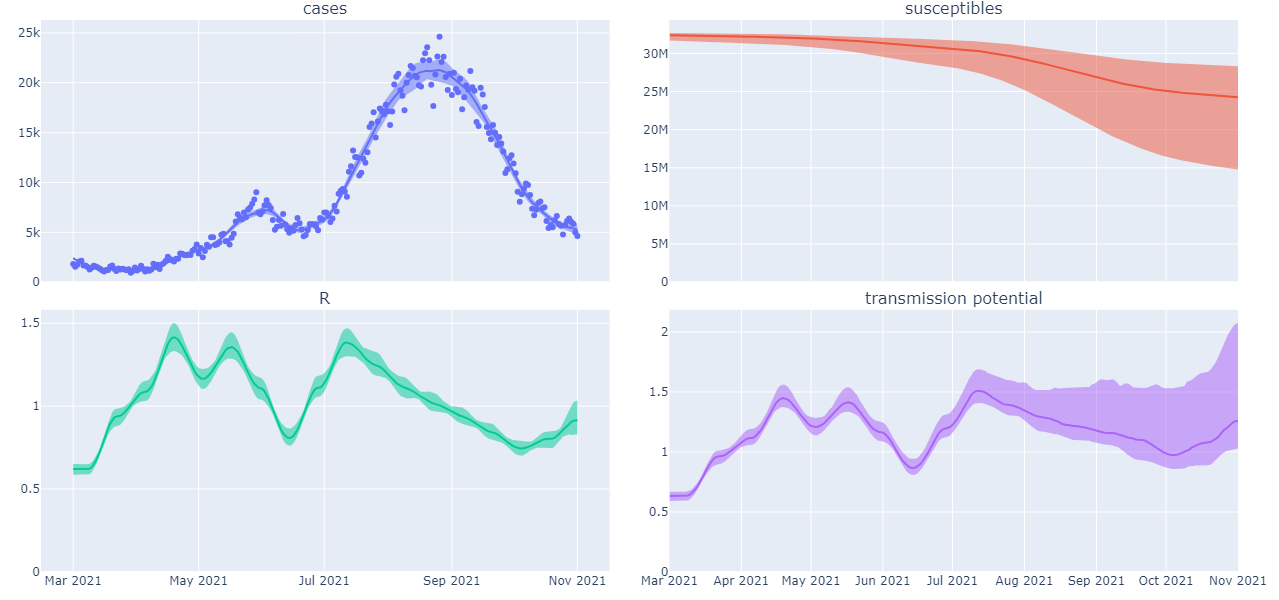

In [116]:
def get_full_result(gen_mean, gen_sd, proc, cdr, rt_init, report_mean, report_sd):
    return renew_model.renewal_func(gen_mean, gen_sd, proc, cdr, rt_init, report_mean, report_sd)

full_wrap = jit(get_full_result)
spaghetti = get_spaghetti_from_params(renew_model, sample_params, full_wrap)
quantiles_df = get_quant_df_from_spaghetti(renew_model, spaghetti, quantiles=[0.05, 0.5, 0.95])
plot_uncertainty_patches(quantiles_df, select_data, qual_colours.Plotly).update_layout(showlegend=False)

In [117]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cdr,0.279,0.112,0.112,0.500,0.010,0.009,144.0,46.0,1.02
dispersion,0.115,0.006,0.104,0.125,0.000,0.000,1172.0,1384.0,1.00
gen_mean,7.428,0.405,6.578,8.083,0.016,0.012,690.0,1098.0,1.01
gen_sd,4.056,0.481,3.089,4.848,0.013,0.009,1416.0,1267.0,1.00
proc[0],0.414,0.060,0.307,0.525,0.003,0.002,395.0,433.0,1.01
proc[1],0.152,0.060,0.045,0.264,0.002,0.002,749.0,1160.0,1.00
proc[2],0.267,0.059,0.148,0.373,0.001,0.001,1681.0,1259.0,1.00
proc[3],-0.188,0.058,-0.301,-0.084,0.001,0.001,1841.0,1486.0,1.00
proc[4],0.160,0.058,0.044,0.261,0.001,0.001,2087.0,1253.0,1.01
proc[5],-0.192,0.062,-0.308,-0.077,0.001,0.001,1800.0,980.0,1.01


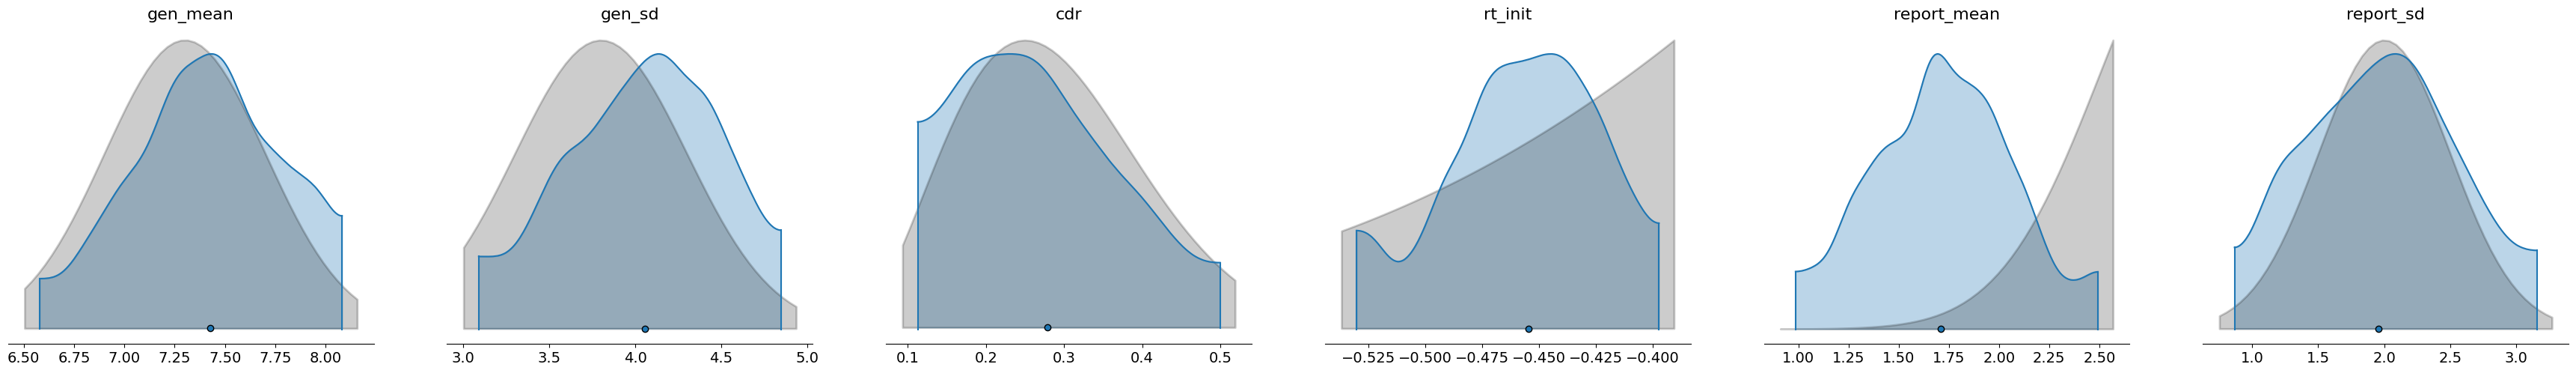

In [118]:
plot_post_prior_comparison(idata, list(priors.keys()), priors);